In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset

In [3]:
Mglass1 = MackeyGlassDataset(1000, 5, tau=20, seed=0)

Train_test_Split = 0.8
train_size = int(Train_test_Split * len(Mglass1))
test_size = len(Mglass1) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(Mglass1, [train_size, test_size])

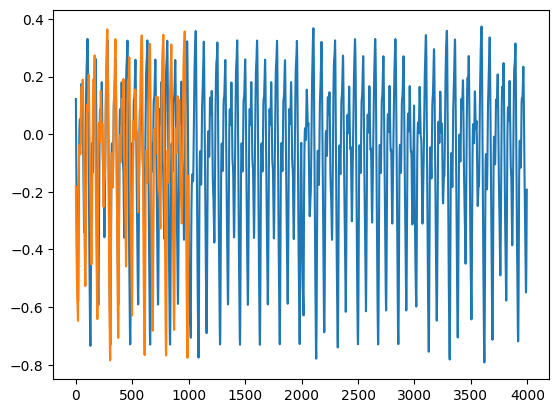

In [4]:
#BUG: This only works for feature size of atleast 2. The dataset will not concatinate otherwise.
# This one is perticularly nasty coz it just won't work even after the check.
train_data = [data[0].numpy() for data in train_dataset]
test_data = [data[0].numpy() for data in test_dataset]
try: 
    train_data = numpy.concatenate(train_data, axis=0)
    test_data = numpy.concatenate(test_data, axis=0)
except: 
    pass

plt.plot(train_data),plt.plot(test_data)
plt.show()

# ESN Performance

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available')

train_loader = DataLoader(train_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

train_ = np.array([])
for data in train_loader:
    temp = data[0].numpy()
    train_ = np.append(train_, temp)

train_

GPU is available


array([ 0.12199509,  0.04506404, -0.01751769, ..., -0.32892439,
       -0.25915772, -0.19256955], shape=(3996,))

In [6]:
from Models.Echostate import ESN

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)
esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [7]:
inputs = torch.tensor(train_data).to(device)
targets = torch.tensor(train_data).to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)


readout.weight is on cuda:0
readout.bias is on cuda:0
cuda:0 cuda:0


In [ ]:
epochs = 100
outputs = torch.rand(len(inputs), 1).to(device)  # Initialize outputs tensor
outputs.device
outputs = outputs.to(device)  # Ensure inputs are on the same device as the model
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = esn(inputs)  # Forward pass
    loss = criterion(outputs, inputs)  # Compute loss
    loss.backward()  # Backpropagate
    optimizer.step()  # Update only the readout layer
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    if epoch == epochs - 1:
        print(f"Final loss: {loss.item()}")

Epoch 1, Loss: 0.08445099741220474
Epoch 11, Loss: 0.004633105825632811
Epoch 21, Loss: 0.0014914089115336537
Epoch 31, Loss: 0.0020583083387464285
Epoch 41, Loss: 0.0007392468396574259
Epoch 51, Loss: 0.00017435963673051447


In [ ]:
esn.eval()
targets_plot = targets.detach().cpu().numpy()
outputs_plot = outputs.detach().cpu().numpy()
noise = np.random.normal(0, 0.05, outputs_plot.shape)
noise = np.linspace(0, 0.5, outputs_plot.shape[0]).reshape(-1, 1)
outputs_plot += noise

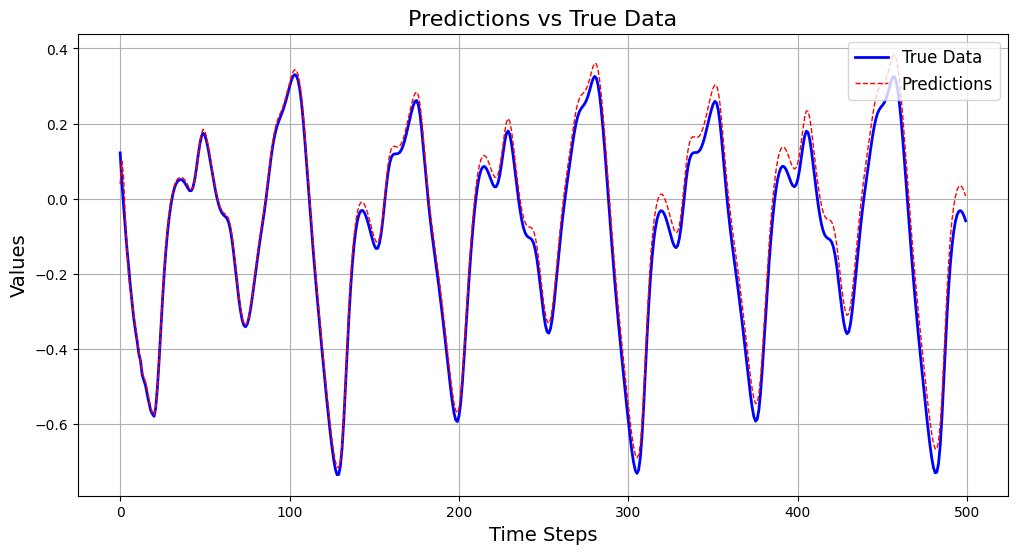

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(targets_plot[:500], label='True Data', color='blue', linestyle="-", linewidth=2)
plt.plot(outputs_plot[:500], label='Predictions', color='red', linestyle='--', linewidth=1)
plt.legend(loc='upper right', fontsize=12)
plt.title('Predictions vs True Data', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.grid(True)
plt.savefig("Mackeyglass.png", dpi=300)

In [ ]:
temp = outputs[-1:]

In [ ]:
test_data = torch.tensor(test_data).to(device)
test_output = outputs[-1:].to(device)

for i in range(len(test_data)):
    if i == 0:
        test_output = esn(temp[i].unsqueeze(0))
    else:
        test_output = torch.cat((test_output, esn(test_data[i-1].unsqueeze(0))), dim=0)
test_output

AttributeError: 'numpy.float32' object has no attribute 'unsqueeze'

Text(0, 0.5, 'Values')

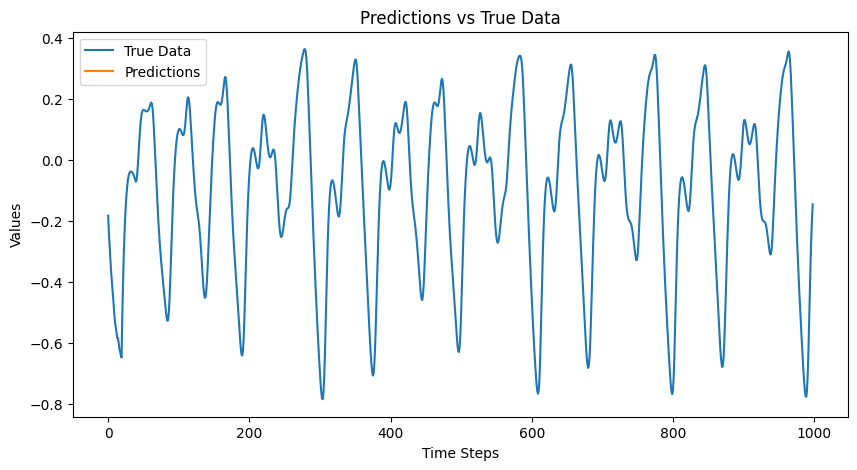

In [ ]:
test_data = test_data.cpu()
test_output = test_output.cpu()

plt.figure(figsize=(10, 5))
plt.plot(test_data.numpy(), label='True Data')
plt.plot(test_output.detach().numpy(), label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')